In [87]:
import numpy as np
from sklearn import datasets
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
x = torch.linspace(-2, 2, 500)
#z = torch.linspace(-2, 2, 500)
y = x.pow(3) - x.pow(2) + 3*torch.rand(x.size())

z = x.pow(3)+ (torch.rand(x.size())).pow(2) + 3*torch.rand(x.size())

x = torch.unsqueeze(x, dim=1)
y = torch.unsqueeze(y, dim=1)
z = torch.unsqueeze(z,dim=1)

input=torch.hstack((x,z))
input2=torch.hstack((x,z))



In [90]:
#2 layer BNN 
num_features = 2
regression_out=1

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=num_features, out_features=150),
    nn.Tanh(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=150, out_features=regression_out),
    #nn.Tanh(),
)

In [91]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [92]:
kl_weight = 0.1

In [93]:
mse_per_iteration=[]
kl_per_iteration=[]
cost_arr=[]

for step in range(3000):
    pre = model(input)
    mse = mse_loss(pre, y)
    kl = kl_loss(model)
    cost = mse + kl_weight*kl
    mse_per_iteration.append(mse.item())
    kl_per_iteration.append(kl.item())
    cost_arr.append(cost.item())
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 1.22, KL : 2.82


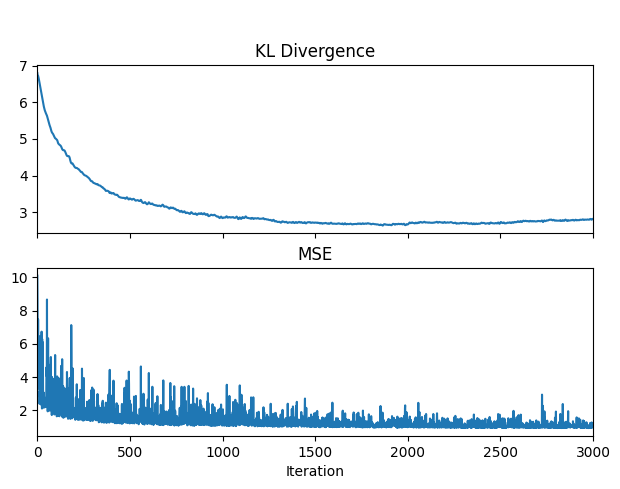

In [94]:
fig, axs = plt.subplots(2,sharex=True)
fig.suptitle(' ')
fig.tight_layout(pad=1.5)
axs[0].plot(kl_per_iteration)
axs[0].set_title('KL Divergence')
axs[1].plot(mse_per_iteration)
axs[1].set_title('MSE')
axs[1].set(xlabel='Iteration')

plt.xlim([0, 3000])

for ax in axs:
    ax.label_outer()

Text(0.5, 1.0, 'Moving STD of MSE')

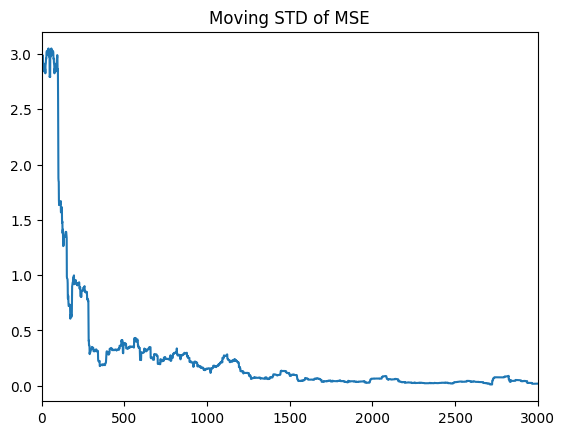

In [95]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

mse_np=np.array(mse_per_iteration)

a = np.var(rolling_window(mse_np, 100), axis=-1)

plt.xlim([0, 3000])

plt.plot(a)
plt.title(label="Moving STD of MSE")

In [96]:
x_test = torch.linspace(-2, 2, 500)
#z = torch.linspace(-2, 2, 500)
y_test = x_test.pow(3) - x_test.pow(2) + 3*torch.rand(x_test.size())

z_test = x_test.pow(3)+ (torch.rand(x_test.size())).pow(2) + 4*torch.rand(x_test.size())

x_test = torch.unsqueeze(x_test, dim=1)
y_test = torch.unsqueeze(y_test, dim=1)
z_test = torch.unsqueeze(z_test,dim=1)

input_test=torch.hstack((x_test,z_test))

#print(input_test)

/tmp/ipykernel_10992/1955944450.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x_b,y_b,z_rl,"ro",alpha=0.5,color='green', marker='o', linestyle='dashed',
/tmp/ipykernel_10992/1955944450.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_b,y_b,z_rl,"ro",alpha=0.5,color='green', marker='o', linestyle='dashed',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


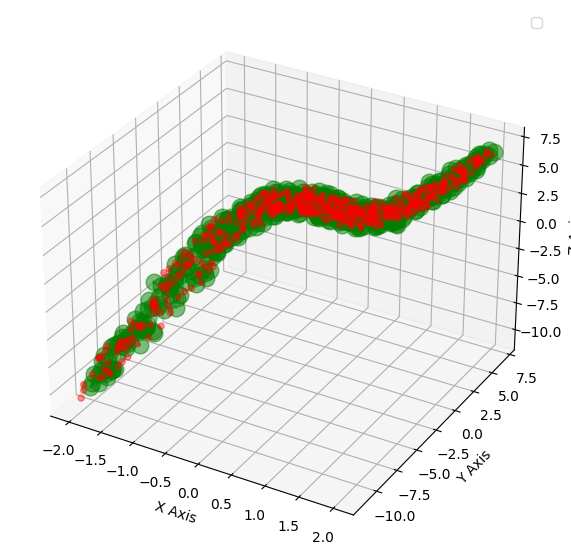

In [106]:
from matplotlib import cm
z_predict = model(input_test)
z_rl=model(input2)

x_n=x_test.detach().numpy()
y_n=y_test.detach().numpy()
z_n=z_predict.detach().numpy()

x_b=x.detach().numpy()
y_b=y.detach().numpy()
z_rl=z_predict.detach().numpy()




#print(x_n,y_n,z_n)

fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(projection='3d')

ax.scatter(x_n, y_n, z_n,alpha=0.4,color='red')
ax.plot(x_b,y_b,z_rl,"ro",alpha=0.5,color='green', marker='o', linestyle='dashed',

     linewidth=2, markersize=12)

ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")




plt.legend()

plt.show()